***Introduction du projet : Prédiction des désabonnements chez SyriaTel***

L’objectif de ce projet est de prédire si un client cessera bientôt de faire affaire avec SyriaTel, une société de télécommunications. Ce type de problème est appelé classification binaire, où la variable cible indique si un client va rester ou partir. Identifier les clients à risque de désabonner permet à l’entreprise de mettre en place des actions ciblées pour réduire les pertes financières et améliorer la fidélisation.

***Méthodologie et étapes du projet***

Pour atteindre cet objectif, le projet suivra les étapes suivantes :

1- Exploration et compréhension des données
   
   Analyse du dataset pour identifier les types de variables, les valeurs manquantes et les déséquilibres de classes.
  
   Compréhension des caractéristiques des clients et de leur comportement.

2- Préparation des données
  
   Nettoyage des données
  
   Encodage des variables catégorielles et standardisation des variables numériques.

3- Séparation du dataset en ensembles d’entraînement et de test.
   
   Construction des modèles de classification
   
   Développement de plusieurs modèles : régression logistique, arbre de décision.

4- Optimisation du meilleur modèle

5-Analyse des matrices de confusion pour comprendre les performances sur chaque classe.
  
  Interprétation et recommandations
  
  Identification des facteurs clés influençant le churn.

Proposition de stratégies pour réduire le désabonnement et fidéliser les clients à risque.

***Étape 1 : Exploration des données***

Objectif : Comprendre le dataset, les types de variables, la distribution de la cible et détecter les valeurs manquantes ou aberrantes.

In [1]:
import pandas as pd
import numpy as np
df = pd.read_csv('bigml_59.csv')

print(df.head())

  state  account length  area code phone number international plan  \
0    KS             128        415     382-4657                 no   
1    OH             107        415     371-7191                 no   
2    NJ             137        415     358-1921                 no   
3    OH              84        408     375-9999                yes   
4    OK              75        415     330-6626                yes   

  voice mail plan  number vmail messages  total day minutes  total day calls  \
0             yes                     25              265.1              110   
1             yes                     26              161.6              123   
2              no                      0              243.4              114   
3              no                      0              299.4               71   
4              no                      0              166.7              113   

   total day charge  ...  total eve calls  total eve charge  \
0             45.07  ...           

In [2]:
# Dimensions du dataset (nb de lignes et colonnes)
print(df.shape)

(3333, 21)


In [3]:
# Informations sur les colonnes
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 21 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   state                   3333 non-null   object 
 1   account length          3333 non-null   int64  
 2   area code               3333 non-null   int64  
 3   phone number            3333 non-null   object 
 4   international plan      3333 non-null   object 
 5   voice mail plan         3333 non-null   object 
 6   number vmail messages   3333 non-null   int64  
 7   total day minutes       3333 non-null   float64
 8   total day calls         3333 non-null   int64  
 9   total day charge        3333 non-null   float64
 10  total eve minutes       3333 non-null   float64
 11  total eve calls         3333 non-null   int64  
 12  total eve charge        3333 non-null   float64
 13  total night minutes     3333 non-null   float64
 14  total night calls       3333 non-null   

In [4]:
# Aperçu des valeurs manquantes
print(df.isnull().sum())

state                     0
account length            0
area code                 0
phone number              0
international plan        0
voice mail plan           0
number vmail messages     0
total day minutes         0
total day calls           0
total day charge          0
total eve minutes         0
total eve calls           0
total eve charge          0
total night minutes       0
total night calls         0
total night charge        0
total intl minutes        0
total intl calls          0
total intl charge         0
customer service calls    0
churn                     0
dtype: int64


In [5]:
# Distribution de la cible 'Churn'
print(df['churn'].value_counts())

churn
False    2850
True      483
Name: count, dtype: int64


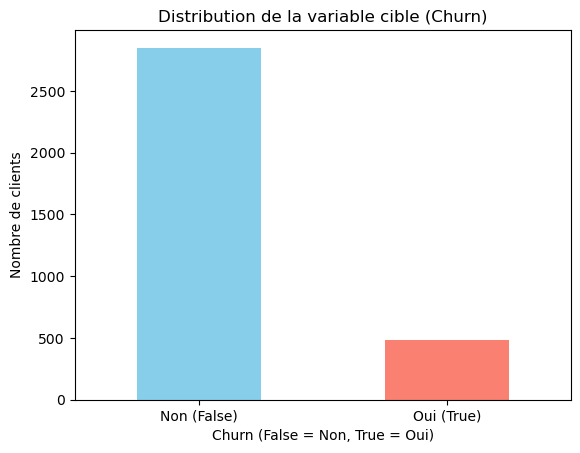

In [6]:
#Visualisation de la distribution de la variable

import matplotlib.pyplot as plt


df['churn'].value_counts().plot(kind='bar', color=['skyblue','salmon'])
plt.title("Distribution de la variable cible (Churn)")
plt.xlabel("Churn (False = Non, True = Oui)")
plt.ylabel("Nombre de clients")
plt.xticks([0,1], ["Non (False)", "Oui (True)"], rotation=0)
plt.show()

Le jeu de données est déséquilibré (85 % non-churn, 15 % churn), donc on utilisera class_weight='balanced' pour balancer le jeu de données lors de la construction des modèles.

***Étape 2 : Préparation des données***

Objectif : Mettre les données sous une forme exploitable par les modèles de classification.


1- Nettoyage des données.

2- Encodage des variables catégorielles (One-Hot).

3- Séparation en train/test sets avec stratification pour maintenir la proportion de classes.

In [7]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Charger le dataset
df = pd.read_csv("bigml_59.csv")

# Nettoyage des données
df = df.drop(columns=["phone number"])

# Encodage des variables catégorielles
df = pd.get_dummies(df, columns=["state"], drop_first=True)

# Binary encoding pour 'international plan' et 'voice mail plan'
df["international plan"] = df["international plan"].map({"yes": 1, "no": 0})
df["voice mail plan"] = df["voice mail plan"].map({"yes": 1, "no": 0})

# Séparation des features et de la cible
X = df.drop(columns=["churn"])
y = df["churn"].astype(int)  # 0 = Non, 1 = Oui

# Split train/test 
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Standardisation des variables numériques
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

***Étape 3 : Construction des modèles***

Objectif : Créer plusieurs modèles de classification pour prédire les désabonnements

1- Régression logistique.

2- Arbre de décision.

In [8]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Régression Logistique
log_model = LogisticRegression(class_weight='balanced', random_state=42)
log_model.fit(X_train_scaled, y_train)
y_pred_log = log_model.predict(X_test_scaled)

# Arbre de Décision
dt_model = DecisionTreeClassifier(class_weight='balanced', random_state=42)
dt_model.fit(X_train_scaled, y_train)
y_pred_dt = dt_model.predict(X_test_scaled)

# Évaluation des modèles
def evaluate_model(y_true, y_pred, model_name):
    print(f"\n===== {model_name} =====")
    print("Accuracy:", round(accuracy_score(y_true, y_pred), 3))
    print(classification_report(y_true, y_pred))
    print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred))

# Évaluer Logistique Régression
evaluate_model(y_test, y_pred_log, "Logistic Regression")

# Évaluer Arbre de décision
evaluate_model(y_test, y_pred_dt, "Decision Tree")



===== Logistic Regression =====
Accuracy: 0.747
              precision    recall  f1-score   support

           0       0.94      0.75      0.84       570
           1       0.33      0.70      0.45        97

    accuracy                           0.75       667
   macro avg       0.63      0.73      0.64       667
weighted avg       0.85      0.75      0.78       667

Confusion Matrix:
 [[430 140]
 [ 29  68]]

===== Decision Tree =====
Accuracy: 0.892
              precision    recall  f1-score   support

           0       0.94      0.94      0.94       570
           1       0.63      0.63      0.63        97

    accuracy                           0.89       667
   macro avg       0.78      0.78      0.78       667
weighted avg       0.89      0.89      0.89       667

Confusion Matrix:
 [[534  36]
 [ 36  61]]


***Analyse des résultats de chaque modèle***

**Régression logistique** :

Precision faible (0.33) → beaucoup de faux positifs : le modèle prédit des clients qui quittent (Churn) pour des clients qui ne quittent pas (non Churn).

Recall correct (0.70) → détecte bien une partie des vrais clients qui quittent, mais au prix de beaucoup de fausses alertes.

F1-score global faible (0.45) → déséquilibre entre précision et rappel.

**Arbre de décision** :

Precision et Recall équilibrés (0.63 chacun) → moins de faux positifs et de faux négatifs.

F1-score plus élevé (0.63) → meilleur compromis entre précision et rappel pour la classe minoritaire.

**Conclusion** :

L’arbre de décision est plus performant que la régression logistique sur ce jeu de données.

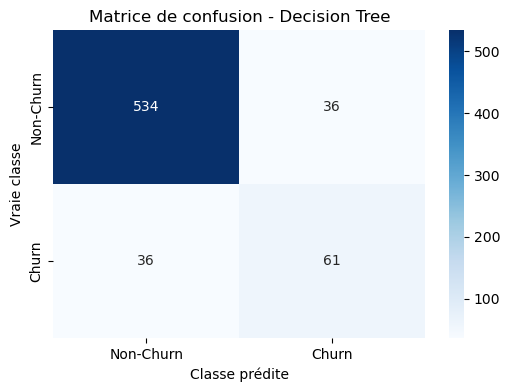

In [9]:
# Visualisation de la matrice de confusion
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Matrice de confusion pour l'arbre de décision
cm = confusion_matrix(y_test, y_pred_dt)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Non-Churn", "Churn"], yticklabels=["Non-Churn", "Churn"])
plt.ylabel("Vraie classe")
plt.xlabel("Classe prédite")
plt.title("Matrice de confusion - Decision Tree")
plt.show()

C:\Users\rnael\AppData\Local\Temp\ipykernel_2664\2856842935.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=models, y=f1_scores, palette='pastel')


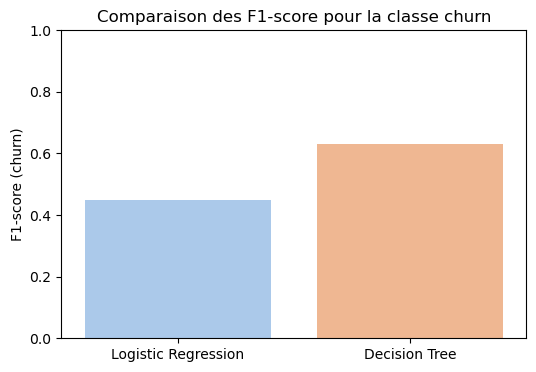

In [10]:
# Comparaison des f1_score pour les modèles
import numpy as np

models = ['Logistic Regression', 'Decision Tree']
f1_scores = [0.45, 0.63]  # F1-score pour la classe churn

plt.figure(figsize=(6,4))
sns.barplot(x=models, y=f1_scores, palette='pastel')
plt.ylabel("F1-score (churn)")
plt.title("Comparaison des F1-score pour la classe churn")
plt.ylim(0,1)
plt.show()

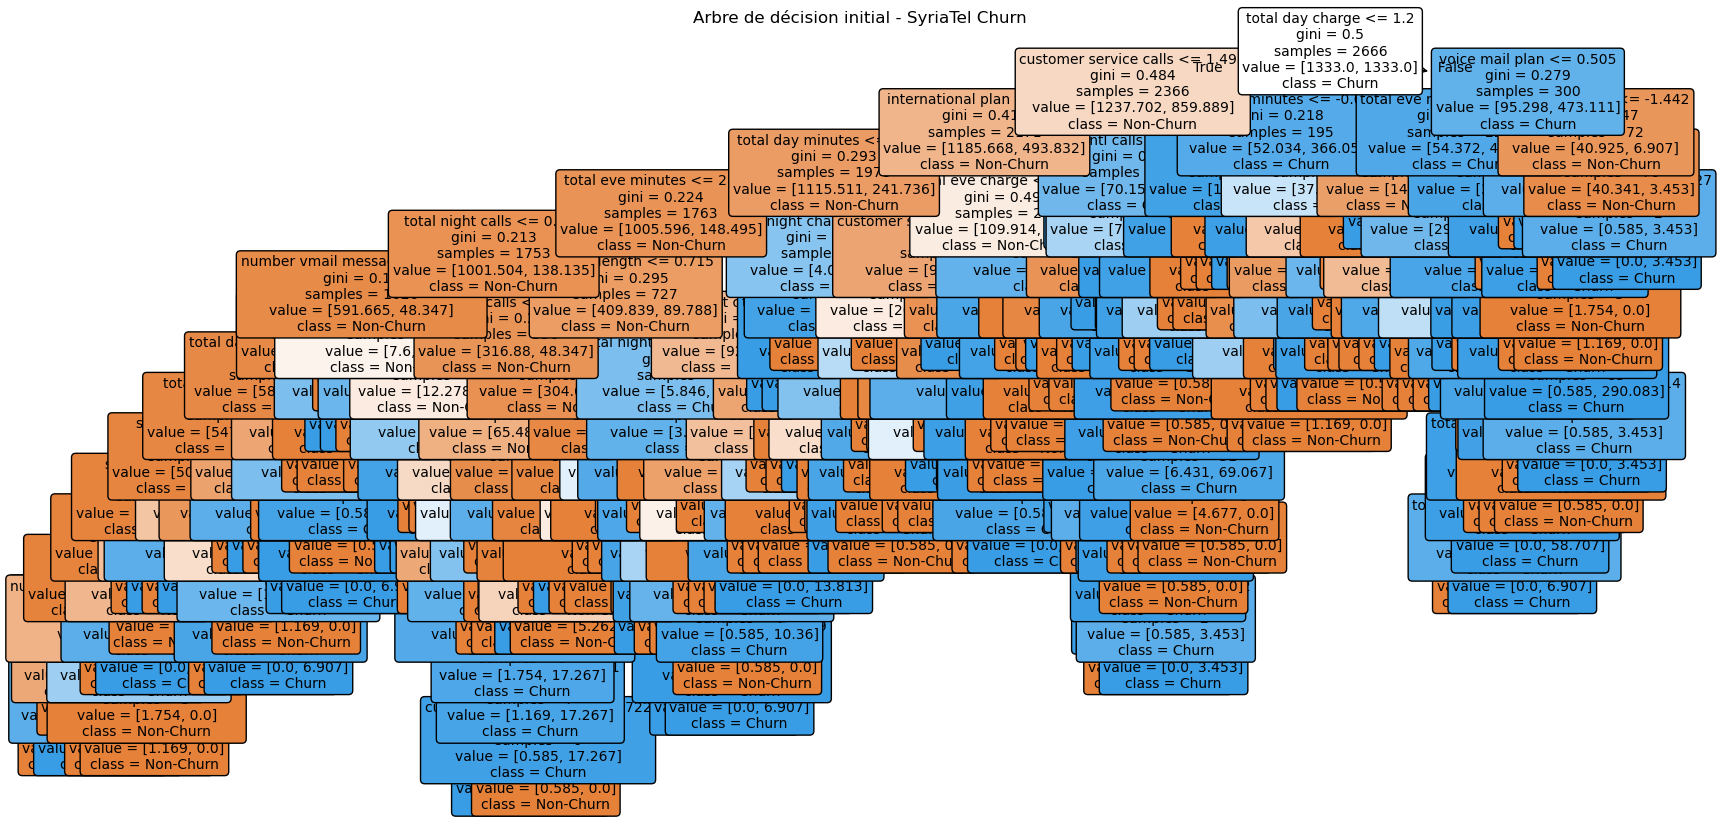

In [11]:
# Visualisation de l'arbre de décision

from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

# Visualisation de l'arbre initial
plt.figure(figsize=(20,10))
plot_tree(dt_model,  # l'arbre initial
          feature_names=X.columns, 
          class_names=['Non-Churn', 'Churn'], 
          filled=True, 
          rounded=True, 
          fontsize=10)
plt.title("Arbre de décision initial - SyriaTel Churn")
plt.show()

***Étape 4: Optimisation de l'arbre de décision***

Objectif :

1- Réduire les faux négatifs et faux positifs pour la classe Churn.

2- Améliorer le F1-score sur la classe minoritaire.

In [12]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier

# Définir le modèle de base
dt = DecisionTreeClassifier(random_state=42, class_weight='balanced')

# Grille d’hyperparamètres
param_grid = {
    'max_depth': [3, 5, 7, 9, None],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 5, 10],
    'criterion': ['gini', 'entropy']
}

# Recherche avec validation croisée
grid_search = GridSearchCV(dt, param_grid, cv=5, scoring='f1', n_jobs=-1)
grid_search.fit(X_train_scaled, y_train)

# Meilleur modèle
best_dt = grid_search.best_estimator_

# Prédiction sur le test 
y_pred_best = best_dt.predict(X_test_scaled)

# Évaluation
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

print("Best parameters:", grid_search.best_params_)
print("Accuracy:", round(accuracy_score(y_test, y_pred_best), 3))
print("Classification Report:\n", classification_report(y_test, y_pred_best))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_best))


Best parameters: {'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 10}
Accuracy: 0.891
Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.93      0.94       570
           1       0.61      0.68      0.64        97

    accuracy                           0.89       667
   macro avg       0.78      0.80      0.79       667
weighted avg       0.90      0.89      0.89       667

Confusion Matrix:
 [[528  42]
 [ 31  66]]


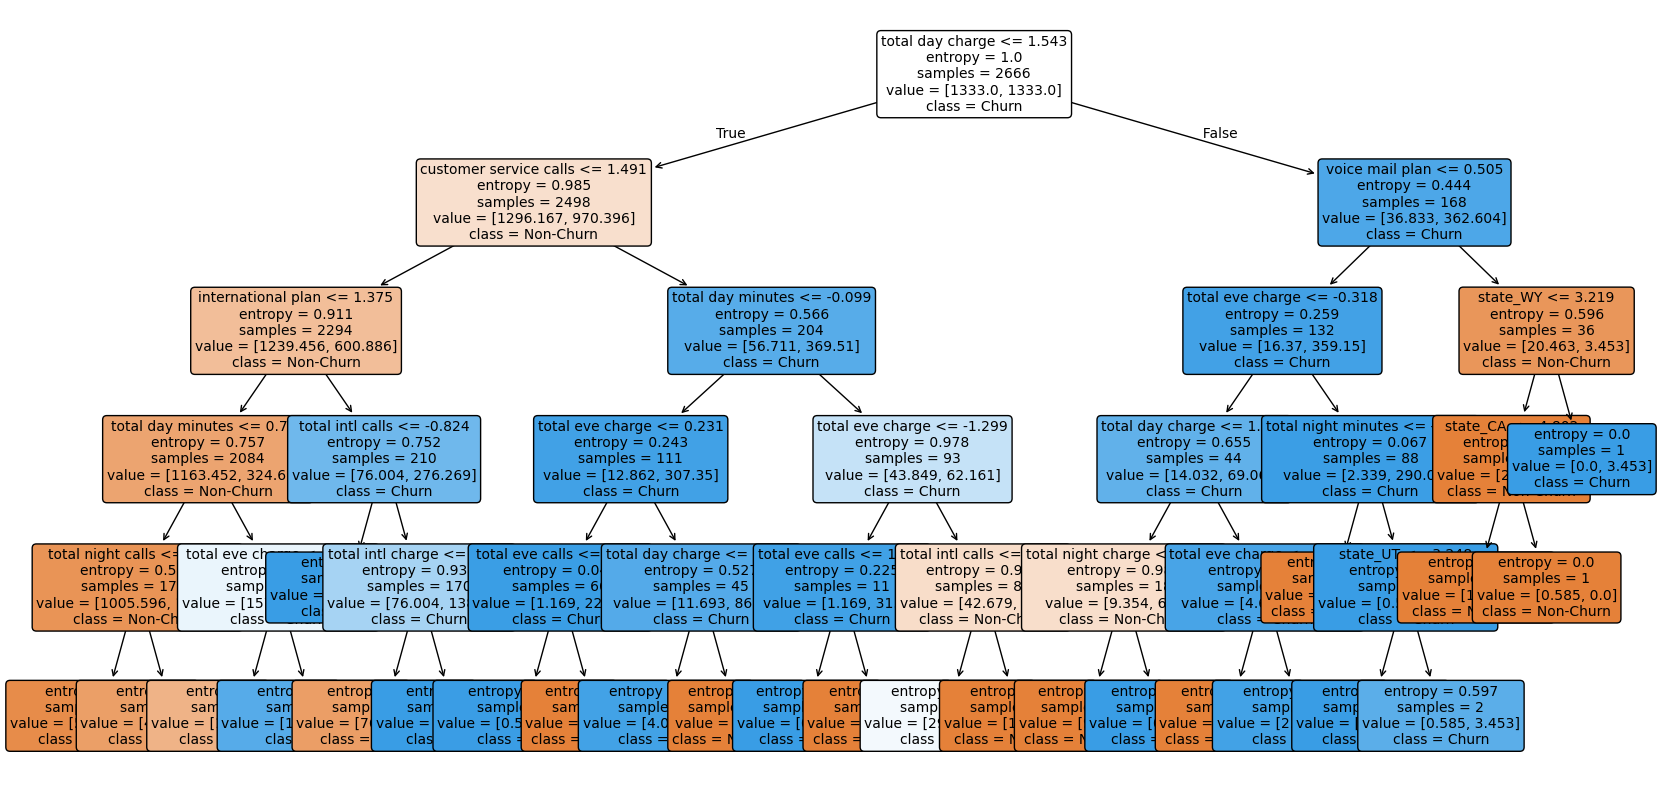

In [13]:
#Visualisation de l'arbre de décision

from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plot_tree(best_dt, 
          feature_names=X.columns, 
          class_names=['Non-Churn', 'Churn'], 
          filled=True, 
          rounded=True, 
          fontsize=10)
plt.show()

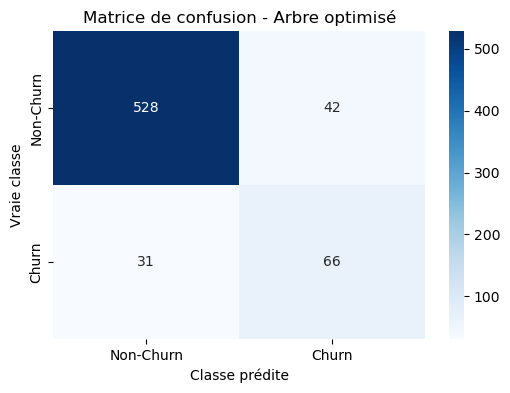

In [14]:
#Visualisation de la matrice de confusion de l'arbre optimisé.

import seaborn as sns
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred_best)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Churn','Churn'], yticklabels=['Non-Churn','Churn'])
plt.ylabel("Vraie classe")
plt.xlabel("Classe prédite")
plt.title("Matrice de confusion - Arbre optimisé")
plt.show()

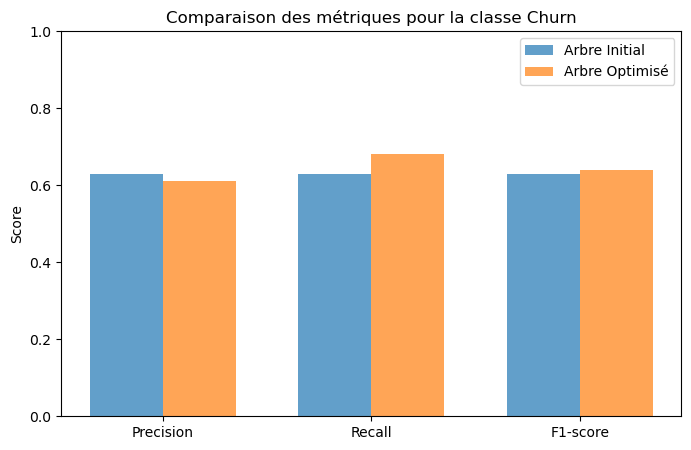

In [15]:
#Visualisation de la comparaison entre l'arbre initial et l'abre optimisé.

import matplotlib.pyplot as plt
import numpy as np

# Scores avant optimisation (arbre initial)
initial_scores = {'Precision': 0.63, 'Recall': 0.63, 'F1-score': 0.63}

# Scores après optimisation (arbre optimisé)
optimized_scores = {'Precision': 0.61, 'Recall': 0.68, 'F1-score': 0.64}

metrics = ['Precision', 'Recall', 'F1-score']
x = np.arange(len(metrics))
width = 0.35

plt.figure(figsize=(8,5))
plt.bar(x - width/2, [initial_scores[m] for m in metrics], width, label='Arbre Initial', alpha=0.7)
plt.bar(x + width/2, [optimized_scores[m] for m in metrics], width, label='Arbre Optimisé', alpha=0.7)

plt.xticks(x, metrics)
plt.ylim(0,1)
plt.ylabel('Score')
plt.title('Comparaison des métriques pour la classe Churn')
plt.legend()
plt.show()


***Conclusion***

D’après les résultats de l'arbre de décision optimisé et la matrice de confusion :

[[528  42]
 [ 31  66]]


Vrai positif (TP) = 66 

Faux positif (FP) = 42

Donc le nombre total de clients identifiés comme Churn par le modèle est :

TP + FP = 66 + 42 
TP + FP=66+42=108

108 clients ont été identifiés comme churn par le modèle.